Импорт

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math


---
Загрузка данных из .csv файла




In [ ]:
df = pd.read_csv('INTC.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format='%Y%m%d')
df.set_index('<DATE>', inplace=True)
df = df.filter(['<CLOSE>'])
df

<CLOSE>
<DATE>             
2015-01-02   36.350
2015-01-05   35.960
2015-01-06   35.270
2015-01-07   36.030
2015-01-08   36.695
...             ...
2022-12-23   26.100
2022-12-27   25.950
2022-12-28   25.540
2022-12-29   26.200
2022-12-30   26.430

[2012 rows x 1 columns]

---
Определение значения глубины 

In [ ]:
depth = 70

---
Разделение данных на наборы для обучения и тестирования, нормирование данных

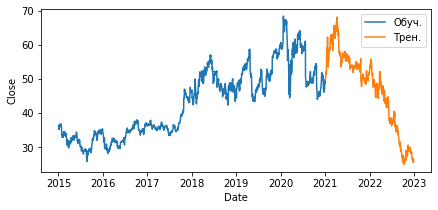

In [ ]:
tr_data_len = math.ceil(.75 * len(df))


plt.figure(figsize=(7,3))
plt.plot(df[:tr_data_len]['<CLOSE>'], label='Обуч.')
plt.plot(df[tr_data_len:]['<CLOSE>'], label='Трен.')

plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


values = df.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(values)


train = scaled_values[:tr_data_len, :]
test = scaled_values[tr_data_len-depth:, :]

---
Формирование выборок

In [ ]:
x_train = [] 
y_train = []
for i in range(depth, len(train)):
  x_train.append(train[i-depth:i,0])
  y_train.append(train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_test = [] 
y_test = []
for i in range(depth, len(test)):
  x_test.append(test[i-depth:i,0])
  y_test.append(test[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

---
Создание и обучение НС

In [ ]:
model = Sequential()
model.add(GRU(units=60,input_shape= (x_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1409/1409 [==============================] - 29s 20ms/step - loss: 0.0248
Epoch 2/3
1409/1409 [==============================] - 29s 21ms/step - loss: 0.0179
Epoch 3/3
1409/1409 [==============================] - 28s 20ms/step - loss: 0.0182


---
Предсказание значений и вывод на график

16/16 [==============================] - 0s 20ms/step


<ipython-input-17-f746e1af5de3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['predict'] = predict


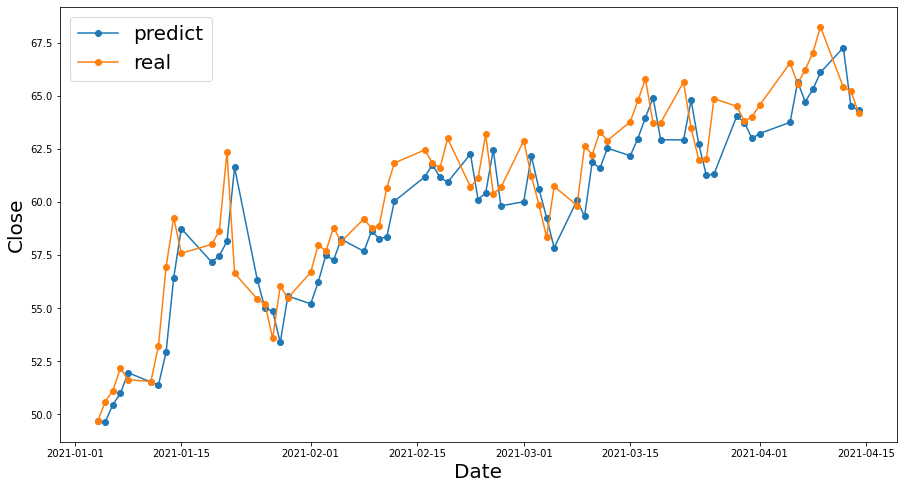

<CLOSE>    predict
<DATE>                        
2021-01-04    49.67  49.694141
2021-01-05    50.61  49.644337
2021-01-06    51.12  50.464672
2021-01-07    52.18  50.990879
2021-01-08    51.64  51.966835
...             ...        ...
2022-12-23    26.10  27.445688
2022-12-27    25.95  27.389254
2022-12-28    25.54  27.286406
2022-12-29    26.20  26.959801
2022-12-30    26.43  27.371294

[503 rows x 2 columns]

In [ ]:
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

p_df = df[-predict.size:]
p_df['predict'] = predict

plt.figure(figsize=(15,8))
plt.xlabel('Date',fontsize=20)
plt.ylabel('Close',fontsize=20)

plt.plot(p_df[:70]['predict'],'-o', label='predict')
plt.plot(p_df[:70]['<CLOSE>'],'-o', label='real')
plt.legend(fontsize=20)
plt.show()
p_df

In [ ]:
print(tf.keras.metrics.mean_absolute_error(p_df['<CLOSE>'], p_df['predict']).numpy())
print(tf.keras.metrics.mean_squared_error(p_df['<CLOSE>'], p_df['predict']).numpy())

model.save('myModel')

0.9227104
1.4786415
